<h4>Integrantes</h4>
Ruiz Irisbel - 30.864.236

Sosa Andres - 30.096.794

#### Recoleccion de datos (API)

In [26]:
using JSON
using HTTP

localizacion = "Cusco"
inicio_sem = "2023-06-01"
final_sem = "2023-06-07" 

url = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?q=$(localizacion)&tp=24&date=$(inicio_sem)&enddate=$(final_sem)&format=json&key=790e4819ffc841c5b1810355241106"

respuesta = HTTP.request("GET", url)

if respuesta.status == 200
    data = JSON.parse(String(respuesta.body))
    println("Temperatura media de la semana $inicio_sem hasta el $final_sem de la ciudad de $localizacion (obtenidos datos correctamente)")
else
    println("Error al obtener datos de la semana del $inicio_sem al $final_sem: $(respuesta.status)")
end

temperatura_max = []
temperatura_min = []
temperatura = []

for day in data["data"]["weather"]
    temperaturas_max = day["maxtempC"]
    temperaturas_min = day["mintempC"]

    push!(temperatura_max, temperaturas_max)
    push!(temperatura_min, temperaturas_min)
end

for i in 1:length(temperatura_max)
    a = parse(Int, temperatura_max[i])
    b = parse(Int, temperatura_min[i]) 
    c = a + b
    push!(temperatura, div(c, 2))
end   

println(temperatura)

Temperatura media de la semana 2023-06-01 hasta el 2023-06-07 de la ciudad de Cusco (obtenidos datos correctamente)
Any[11, 10, 10, 10, 9, 10, 9]


### Análisis y Predicción de Datos Meteorológicos con Métodos de Interpolación

<h4>Parte 1: Interpolación de Taylor</h4>

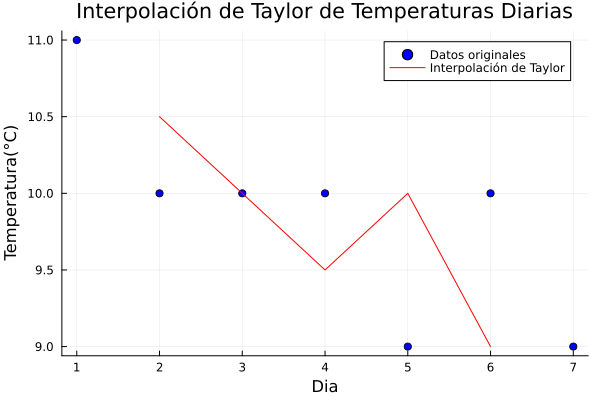

In [36]:
using Plots

temp = temperatura

dias = 1:7

function interpolacion_taylor(x, x0, y0, y1, y2)
    return y0 + (x - x0) * (y1 - y0) + ((x - x0) ^ 2) * (y2 - 2 * y1 + y0) / 2
end

interp = []

for i in 2:length(temp) - 1
    push!(interp, interpolacion_taylor(i, i-1, temp[i-1], temp[i], temp[i+1]))
end

plot(dias, temp, seriestype=:scatter, color=:blue,label="Datos originales")

plot!(2:length(temp)-1, interp, color=:red,seriestype=:line, label="Interpolación de Taylor")
title!("Interpolación de Taylor de Temperaturas Diarias")
xlabel!("Dia")
ylabel!("Temperatura(°C)")




<h4>Parte 2: Interpolación de Lagrange
</h4>

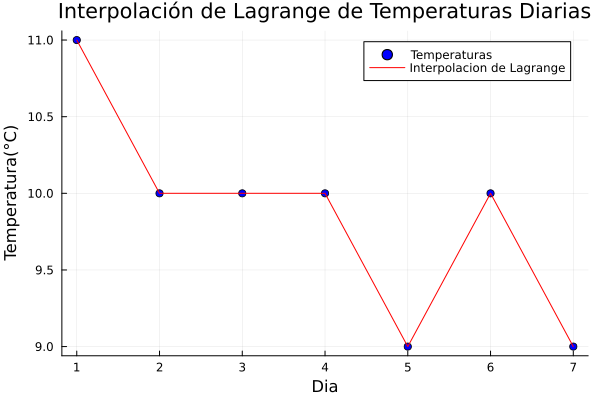

In [35]:
using Plots
# Datos que representa una semana
dias = 1:7
tempe = temperatura

# aplicando la funcion lagrange
function interp_lagrange(x, dias, tempe)
    n = length(dias)
    resultado = 0
    for i in 1:n
        termino = tempe[i]
        for j in 1:n
            if j != i
                termino *= (x - dias[j]) / (dias[i] - dias[j])
            end
        end
        resultado += termino
    end
    return resultado
end

# aqui usamos la interpolacion para sacar un estimado del dia 1 al dia 7
temp_inter = [Int(interp_lagrange(dia, dias, tempe)) for dia in dias]

# Graficamos los datos y la interpolación de Lagrange
scatter(dias, tempe, seriestype=:scatter, color=:blue, label="Temperaturas")
plot!(dias, temp_inter, color=:red,seriestype=:line, label="Interpolacion de Lagrange")
title!("Interpolación de Lagrange de Temperaturas Diarias")
xlabel!("Dia")
ylabel!("Temperatura(°C)")



<h4>Parte 3: Interpolación de Hermite
</h4>

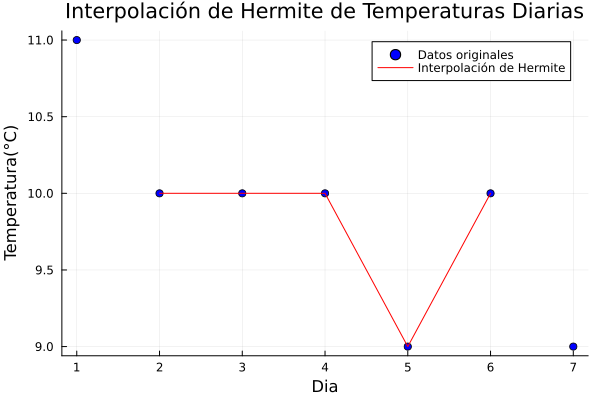

In [33]:
using Plots

temp = temperatura
dias = 1:7

# Calculate the derivative of the temperature data
deriv_temp = diff(temp)

function interpolacion_hermite(x, x0, x1, y0, y1, y0_prime, y1_prime)
    h = x1 - x0
    t = (x - x0) / h
    h00 =  2 * t^3 - 3 * t^2 + 1
    h10 = -2 * t^3 + 3 * t^2
    h01 = t^3 - 2 * t^2 + t
    h11 = t^3 - t^2
    return h00 * y0 + h10 * y1 + h01 * y0_prime * h + h11 * y1_prime * h
end

interp = []

for i in 2:length(temp) - 1
    push!(interp, interpolacion_hermite(i, i-1, i, temp[i-1], temp[i], deriv_temp[i-1], deriv_temp[i]))
end

plot(dias, temp, seriestype=:scatter, color=:blue, label="Datos originales")
plot!(2:length(temp)-1, interp, color=:red, seriestype=:line, label="Interpolación de Hermite")
title!("Interpolación de Hermite de Temperaturas Diarias")
xlabel!("Dia")
ylabel!("Temperatura(°C)")



<h4>Parte 4: Interpolación Polinómica a Trozos
</h4>

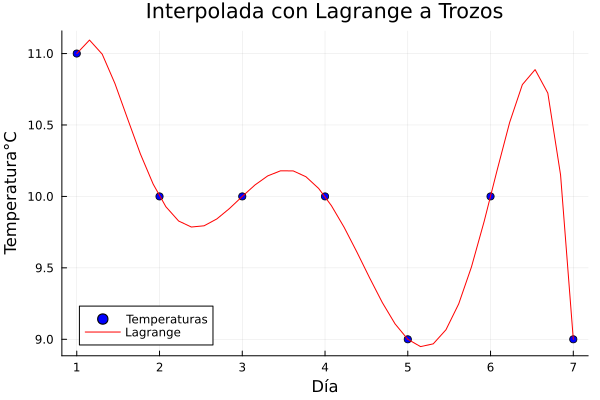

In [34]:
using Plots
# Datos que representa una semana
dias = 1:7
temp = temperatura .|> Int 

# aplicando la funcion lagrange
function inter_lagrange(dias, temp, x_interp)
    n = length(dias)
    lagra = zero(eltype(temp))
    
    for i in 1:n
        term = temp[i]
        for j in 1:n
            if j != i
                term *= (x_interp - dias[j]) / (dias[i] - dias[j])
            end
        end
        lagra += term
    end
    
    return lagra
end

# determina los puntos del periodo del dia 1 al 7 y length el numero de intervalos
x_plot = range(1,length=40, stop=7)
y_plot = map(xi -> inter_lagrange(dias, temp, xi), x_plot)

# Graficamos los datos y la interpolacion de Lagrange
scatter(dias, temp, label="Temperaturas",seriestype=:scatter,color=:blue)
plot!(x_plot, y_plot, label="Lagrange", seriestype=:line, color=:red)
 xlabel!("Día")
ylabel!("Temperatura°C")
title!("Interpolada con Lagrange a Trozos")